# 1-1 结构化数据建模流程
## 数据集概述
titanic数据集的目标是根据乘客信息预测他们再Titanic号撞击沉没后是否能生存
## 结构化数据处理的方式
结构化的数据一般使用Pandas进行处理

In [163]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers
%matplotlib inline

## 读入数据

### 字段说明
* Survied：0代表死亡, 1代表存活 【y标签】
* Pclass: 乘客所持的票类
* Name: 乘客姓名【与预测无关】
* Sex: 性别
* SibSp:兄弟姐妹的个数
* Parch:父母和孩子的个数
* Ticket: 票号【与预测无关】
* Fare: 票价
* Cabin: 所在船舱
* Embarked: 登船港口

In [164]:
dftrain_raw = pd.read_csv('./data/titanic/train.csv')
dftest_raw = pd.read_csv('./data/titanic/test.csv')
dftrain_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S


### label分布情况

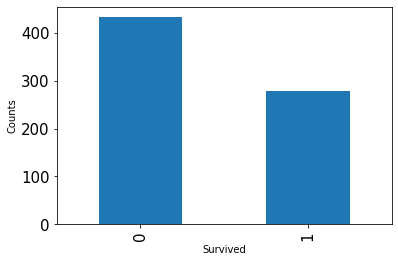

In [19]:
ax = dftrain_raw['Survived'].value_counts().plot(kind='bar', fontsize=15)
ax.set_ylabel('Counts')
ax.set_xlabel('Survived')
plt.show()

In [20]:
help(dftrain_raw['Survived'].value_counts)

Help on method value_counts in module pandas.core.base:

value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True) method of pandas.core.series.Series instance
    Return a Series containing counts of unique values.
    
    The resulting object will be in descending order so that the
    first element is the most frequently-occurring element.
    Excludes NA values by default.
    
    Parameters
    ----------
    normalize : bool, default False
        If True then the object returned will contain the relative
        frequencies of the unique values.
    sort : bool, default True
        Sort by frequencies.
    ascending : bool, default False
        Sort in ascending order.
    bins : int, optional
        Rather than count values, group them into half-open bins,
        a convenience for ``pd.cut``, only works with numeric data.
    dropna : bool, default True
        Don't include counts of NaN.
    
    Returns
    -------
    Series
    
    See Also
 

### 年龄分布情况

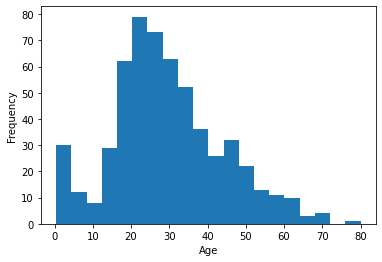

In [23]:
ax = dftrain_raw['Age'].plot(kind='hist', bins=20)
ax.set_ylabel('Frequency')
ax.set_xlabel('Age')
plt.show()

### 死亡和幸存的核密度折线图

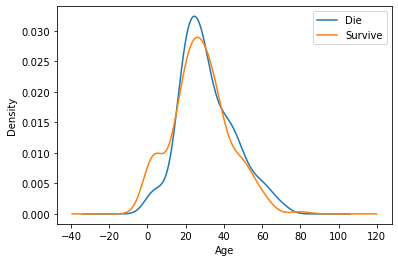

In [27]:
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind='density')  # 死亡
dftrain_raw.query('Survived == 1')['Age'].plot(kind='density') # 幸存
ax.legend(['Die', 'Survive'])
ax.set_ylabel('Density')
ax.set_xlabel('Age')
plt.show()

> 从上图中可以看出来的是, 死亡和幸存较多的人都集中在30岁左右

In [28]:
help(pd.get_dummies)

Help on function get_dummies in module pandas.core.reshape.reshape:

get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None) -> 'DataFrame'
    Convert categorical variable into dummy/indicator variables.
    
    Parameters
    ----------
    data : array-like, Series, or DataFrame
        Data of which to get dummy indicators.
    prefix : str, list of str, or dict of str, default None
        String to append DataFrame column names.
        Pass a list with length equal to the number of columns
        when calling get_dummies on a DataFrame. Alternatively, `prefix`
        can be a dictionary mapping column names to prefixes.
    prefix_sep : str, default '_'
        If appending prefix, separator/delimiter to use. Or pass a
        list or dictionary as with `prefix`.
    dummy_na : bool, default False
        Add a column to indicate NaNs, if False NaNs are ignored.
    columns : list-like, default None
        Colu

In [42]:
def preprocessing(df):
    dfresult = pd.DataFrame()
    # Pclass, 变成one-hot编码
    dfPlass = pd.get_dummies(df['Pclass'], prefix = 'Pclass')
    dfresult = pd.concat([dfresult, dfPlass], axis = 1)
    
    # Sex
    dfSex = pd.get_dummies(df['Sex'], prefix = 'Sex')
    dfresult = pd.concat([dfresult, dfSex], axis = 1)
    
    # Age
    dfresult['Age'] = df['Age'].fillna(0)  # 如果为nan的话就用0填充
    dfresult['Age_null'] = pd.isna(df['Age']).astype('int32')  # 虽然用0填充了，但还需要一个标记，标识这里是否为null
    
    # SibSp, Parch, Fare
    dfresult['SibSp'] = df['SibSp']
    dfresult['Parch'] = df['Parch']
    dfresult['Fare'] = df['Fare']
    
    # Carbin
    dfresult['Cabin_null'] = pd.isna(df['Cabin']).astype('int32')  # 标记是否有船舱
    
    # Embarked
    dfEmbarked = pd.get_dummies(df['Embarked'], dummy_na=True, prefix='Embarked')
    
    dfresult = pd.concat([dfresult, dfEmbarked], axis=1)
    return dfresult

In [45]:
x_train = preprocessing(dftrain_raw)
x_train.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Age_null,SibSp,Parch,Fare,Cabin_null,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,0,0,1,55.0,0,0,0,30.5000,0,0,0,1,0
1,1,0,0,1,0,49.0,0,1,0,76.7292,0,1,0,0,0
2,0,1,0,1,0,36.0,0,0,0,13.0000,1,0,0,1,0
3,0,1,0,0,1,19.0,0,0,0,13.0000,1,0,0,1,0
4,0,0,1,0,1,14.0,0,4,1,39.6875,1,0,0,1,0


In [46]:
y_train = dftrain_raw['Survived']
x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived']
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (712, 15)
x_test shape: (179, 15)


## 定义模型

### Keras构建模型

In [49]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape=(15,))
dense1 = layers.Dense(20, activation = 'relu')(x_input)
dense2 = layers.Dense(10, activation = 'relu')(dense1)
x_output = layers.Dense(1, activation = 'sigmoid')(dense2)
model = tf.keras.Model(inputs = x_input, outputs = x_output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
history = model.fit(x_train, y_train, validation_split=0.2, epochs=30)  # 分割一部分用于数据验证

Epoch 1/30
18/18 [==============================] - 0s 25ms/step - loss: 0.7278 - auc: 0.6326 - val_loss: 0.7086 - val_auc: 0.6565
Epoch 2/30
18/18 [==============================] - 0s 4ms/step - loss: 0.6806 - auc: 0.7129 - val_loss: 0.6932 - val_auc: 0.6558
Epoch 3/30
18/18 [==============================] - 0s 4ms/step - loss: 0.6741 - auc: 0.7163 - val_loss: 0.6841 - val_auc: 0.6543
Epoch 4/30
18/18 [==============================] - 0s 4ms/step - loss: 0.6608 - auc: 0.7743 - val_loss: 0.6708 - val_auc: 0.6968
Epoch 5/30
18/18 [==============================] - 0s 4ms/step - loss: 0.6395 - auc: 0.7644 - val_loss: 0.6587 - val_auc: 0.6788
Epoch 6/30
18/18 [==============================] - 0s 4ms/step - loss: 0.6161 - auc: 0.7614 - val_loss: 0.6514 - val_auc: 0.6705
Epoch 7/30
18/18 [==============================] - 0s 4ms/step - loss: 0.5987 - auc: 0.7529 - val_loss: 0.6476 - val_auc: 0.6822
Epoch 8/30
18/18 [==============================] - 0s 4ms/step - loss: 0.5890 - auc: 0.7

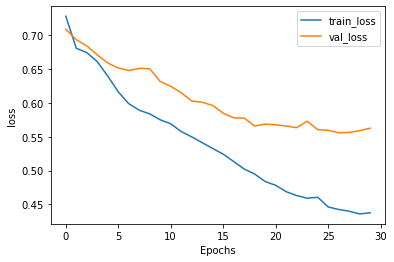

In [57]:
len(history.history['loss'])
# 绘制loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [60]:
# 预测类别
model.evaluate(x_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.4671 - auc: 0.8198


[0.46710455417633057, 0.819786548614502]

In [61]:
# 使用Keras方式保存
model.save('./keras_1-1_model.h5')
del model
model = models.load_model('./keras_1-1_model.h5')
model.evaluate(x_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.4671 - auc: 0.8198


[0.46710455417633057, 0.819786548614502]

### Tensorflow构建动态计算图

In [136]:
def loss_func(y_pred, y):
    epsilon = 1e-7
    loss = -tf.reduce_mean(y * tf.math.log(y_pred + epsilon) + (1 - y) * tf.math.log(1 - y_pred + epsilon))
    return loss

In [160]:
x_train_tensor = x_train.values
y_train_tensor = y_train.values
class MyModel:
    def __init__(self):
        self.w1 = tf.Variable(tf.random.truncated_normal([15, 20], dtype='float32'))
        self.b1 = tf.Variable(tf.random.truncated_normal([1, 20], dtype='float32'))
        self.w2 = tf.Variable(tf.random.truncated_normal([20, 10], dtype='float32'))
        self.b2 = tf.Variable(tf.random.truncated_normal([1, 10], dtype='float32'))
        self.w3 = tf.Variable(tf.random.truncated_normal([10, 1], dtype='float32'))
        self.b3 = tf.Variable(tf.random.truncated_normal([1, 1], dtype='float32'))
        
    def __call__(self, x):
        # InputLayer -> Dense1
        densor1 = x @ self.w1 + self.b1
        # Dense1 -> Dense2
        densor2 = densor1 @ self.w2 + self.b2
        # Dense2 -> sigmoid
        pred = tf.sigmoid(densor2 @ self.w3 + self.b3)
        return pred
# 计算损失
m_model = MyModel()
loss = loss_func(m_model(x_train_tensor), y_train_tensor)
print(loss)

tf.Tensor(7.3237233, shape=(), dtype=float32)


In [161]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss_func(model(inputs), outputs)
        dw1, db1, dw2, db2, dw3, db3 = t.gradient(current_loss, [model.w1, model.b1, model.w2, model.b2, model.w3, model.b3])
        model.w1.assign_sub(learning_rate * dw1)
        model.b1.assign_sub(learning_rate * db1)

        model.w2.assign_sub(learning_rate * dw2)
        model.b2.assign_sub(learning_rate * db2)

        model.w3.assign_sub(learning_rate * dw3)
        model.b3.assign_sub(learning_rate * db3)
        return current_loss

In [162]:
for epoch in range(30):
    current_loss = train(m_model, x_train_tensor, y_train_tensor, learning_rate = 0.1)
    print("epoch:", epoch, " loss:", current_loss)

epoch: 0  loss: tf.Tensor(7.3237233, shape=(), dtype=float32)
epoch: 1  loss: tf.Tensor(6.250588, shape=(), dtype=float32)
epoch: 2  loss: tf.Tensor(5.8712854, shape=(), dtype=float32)
epoch: 3  loss: tf.Tensor(6.339668, shape=(), dtype=float32)
epoch: 4  loss: tf.Tensor(6.3395123, shape=(), dtype=float32)
epoch: 5  loss: tf.Tensor(6.339357, shape=(), dtype=float32)
epoch: 6  loss: tf.Tensor(6.339203, shape=(), dtype=float32)
epoch: 7  loss: tf.Tensor(6.339048, shape=(), dtype=float32)
epoch: 8  loss: tf.Tensor(6.3388925, shape=(), dtype=float32)
epoch: 9  loss: tf.Tensor(6.3360558, shape=(), dtype=float32)
epoch: 10  loss: tf.Tensor(6.3330803, shape=(), dtype=float32)
epoch: 11  loss: tf.Tensor(6.3302727, shape=(), dtype=float32)
epoch: 12  loss: tf.Tensor(6.326312, shape=(), dtype=float32)
epoch: 13  loss: tf.Tensor(6.3211823, shape=(), dtype=float32)
epoch: 14  loss: tf.Tensor(6.3153396, shape=(), dtype=float32)
epoch: 15  loss: tf.Tensor(6.3093104, shape=(), dtype=float32)
epoch: 1